# Variational Autoencoder (VAE)

Check out the sister of the GAN: VAE. In this lab, you'll explore the components of a basic VAE to understand how it works. 

The "AE" in VAE stands for autoencoder. As an autoencoder, the VAE has two parts: an encoder and a decoder. Instead of mapping each image to a single point in $z$-space, the encoder outputs the means and covariance matrices of a multivariate normal distribution where all of the dimensions are independent. You should have had a chance to read more about multivariate normal distributions in last week's assignment, but you can think of the output of the encoder of a VAE this way: the means and standard deviations of a set of independent normal distributions, with one normal distribution (one mean and standard deviation) for each latent dimension. 

![VAE Architecture](vae_architecture.png)
*VAE Architecture Drawing: The encoding outputs a distribution in $z$-space, and to generate an image you sample from the distributon and pass the $z$-space sample to the decoder, which returns an image. VAE latent space visualization from [Hyperspherical Variational Auto-Encoders](https://arxiv.org/abs/1804.00891)*, by Davidson et al. in UAI 2018 

## Encoder and Decoder

For your encoder and decoder, you can use similar architectures that you've seen before, with some tweaks. For example, for the decoder, you can use the DCGAN generator architecture. For the encoder, you can use a classifier that you used before, and instead of having it produce 1 classification output of whether something is a cat or not, for example, you can have it produce 2 different outputs, one for mean and one for standard deviation. Each of those outputs will have dimensionality $z$ to model the $z$ dimensions in the multivariate normal distributions.

In [1]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a encoder block of the VAE, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Encoder: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    '''
    Decoder Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a Decoder block of the VAE, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

# VAE

You can define the VAE using the encoder and decoder as follows. In the forward pass, the VAE samples from the encoder's output distribution before passing a value to the decoder. A common mistake is to pass the mean to the decoder --- this leads to blurrier images and is not the way in which VAEs are designed to be used. So, the steps you'll take are:

1.   Real image input to encoder
2.   Encoder outputs mean and standard deviation
3.   Sample from distribution with the outputed mean and standard deviation
4.   Take sampled value (vector/latent) as the input to the decoder
5.   Get fake sample
6.   Use reconstruction loss between the fake output of the decoder and the original real input to the encoder (more about this later - keep reading!)
7.   Backpropagate through



![VAE Architecture](vae_sampling.png)

## Quick Note on Implementation Notation ("Reparameterization Trick")
Most machine learning frameworks will not backpropagate through a random sample (Step 3-4 above work in the forward pass, but its gradient is not readily implemented for the backward pass using the usual notation). In PyTorch, you can do this by sampling using the `rsample` method, such as in `Normal(mean, stddev).rsample()`. This is equivalent to `torch.randn(z_dim) * stddev + mean`, but **do not use** `torch.normal(mean, stddev)`, as the optimizer will not backpropagate through the expectation of that sample. This is also known as the reparameterization trick, since you're moving the parameters of the random sample outside of the the function to explicitly highlight that the gradient should be calculated through these parameters.

In [2]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    '''
    VAE Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        images: an image tensor with dimensions (batch_size, im_chan, im_height, im_width)
        Returns:
        decoding: the autoencoded image
        q_dist: the z-distribution of the encoding
        '''
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        return decoding, q_dist

## Evidence Lower Bound (ELBO)

When training a VAE, you're trying to maximize the likelihood of the real images. What this means is that you'd like the learned probability distribution to think it's likely that a real image (and the features in that real image) occurs -- as opposed to, say, random noise or weird-looking things. And you want to maximize the likelihood of the real stuff occurring and appropriately associate it with a point in the latent space distribution prior $p(z)$ (more on this below), which is where your learned latent noise vectors will live. However, finding this likelihood explicitly is mathematically intractable. So, instead, you can get a good lower bound on the likelihood, meaning you can figure out what the worst-case scenario of the likelihood is (its lower bound which *is* mathematically tractable) and try to maximize that instead. Because if you maximize its lower bound, or worst-case, then you probably are making the likelihood better too. And this neat technique is known as maximizing the Evidence Lower Bound (ELBO).

Some notation before jumping into explaining ELBO: First, the prior latent space distribution $p(z)$ is the prior probability you have on the latent space $z$. This represents the likelihood of a given latent point in the latent space, and you know what this actually is because you set it in the beginning as a multivariate normal distribution. Additionally, $q(z)$ refers to the posterior probability, or the distribution of the encoded images. Keep in mind that when each image is passed through the encoder, its encoding is a probability distribution.

Knowing that notation, here's the mathematical notation for the ELBO of a VAE, which is the lower bound you want to maximize: $\mathbb{E}\left(\log p(x|z)\right) + \mathbb{E}\left(\log \frac{p(z)}{q(z)}\right)$, which is equivalent to $\mathbb{E}\left(\log p(x|z)\right) - \mathrm{D_{KL}}(q(z|x)\Vert p(z))$

ELBO can be broken down into two parts: the reconstruction loss $\mathbb{E}\left(\log p(x|z)\right)$ and the KL divergence term $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$. You'll explore each of these two terms in the next code and text sections.

### Reconstruction Loss 

Reconstruction loss refers to the distance between the real input image (that you put into the encoder) and the generated image (that comes out of the decoder). Explicitly, the reconstruction loss term is $\mathbb{E}\left(\log p(x|z)\right)$, the log probability of the true image given the latent value. 

For MNIST, you can treat each grayscale prediction as a binary random variable (also known as a Bernoulli distribution) with the value between 0 and 1 of a pixel corresponding to the output brightness, so you can use the binary cross entropy loss between the real input image and the generated image in order to represent the reconstruction loss term. 

In general, different assumptions about the "distribution" of the pixel brightnesses in an image will lead to different loss functions. For example, if you assume that the brightnesses of the pixels actually follow a normal distribution instead of a binary random (Bernoulli) distribution, this corresponds to a mean squared error (MSE) reconstruction loss.

Why the mean squared error? Well, as a point moves away from the center, $\mu$, of a normal distribution, its negative log likelihood increases quadratically. You can also write this as $\mathrm{NLL}(x) \propto (x-\mu)^2$ for $x \sim \mathcal{N}(\mu,\sigma)$. As a result, assuming the pixel brightnesses are normally distributed implies an MSE reconstruction loss. 

In [3]:
reconstruction_loss = nn.BCELoss(reduction='sum')

### KL Divergence 

KL divergence, mentioned in a video (on Inception Score) last week, allows you to evaluate how different one probability distribution is from another. If you have two distributions and they are exactly the same, then KL divergence is equal to 0. KL divergence is close to the notion of distance between distributions, but notice that it's called a divergence, not a distance; this is because it is not symmetric, meaning that $\mathrm{KL}(X\Vert Y)$ is usually not equal to the terms flipped $\mathrm{KL}(Y\Vert X)$. In contrast, a true distance function, like the Euclidean distance where you would take the squared difference between two points, is symmetric where you compare $(A-B)^2$ and $(B-A)^2$. 

Now, you care about two distributions and finding how different they are: (1) the learned latent space $q(z|x)$ that your encoder is trying to model and (2) your prior on the latent space $p(z)$, which you want your learned latent space to be as close as possible to. If both of your distributions are normal distributions, you can calculate the KL divergence, or $\mathrm{D_{KL}}(q(z|x)\Vert p(z))$, based on a simple formula. This makes KL divergence an attractive measure to use and the normal distribution a simultaneously attractive distribution to assume on your model and data. 

Well, your encoder is learning $q(z|x)$, but what's your latent prior $p(z)$? It is actually a fairly simple distribution for the latent space with a mean of zero and a standard deviation of one in each dimension, or $\mathcal{N}(0, I)$. You might also come across this as the *spherical normal distribution*, where the $I$ in $\mathcal{N}(0, I)$ stands for the identity matrix, meaning its covariance is 1 along the entire diagonal of the matrix and if you like geometry, it forms a nice symmetric-looking hypersphere, or a sphere with many (here, $z$) dimensions.

In [4]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

### Further Resources

An accessible but complete discussion and derivation of the evidence lower bound (ELBO) and the theory behind it can be found [at this link](https://deepgenerativemodels.github.io/notes/vae/) and [this lecture](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/slides/lec17.pdf).

## Training a VAE

Here you can train a VAE, once again using MNIST! First, define the dataloader:

In [5]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = datasets.MNIST('.', train=True, transform=transform)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

Then, you can run the training loop to observe the training process:

Epoch 0


100%|██████████| 59/59 [00:05<00:00, 11.57it/s]


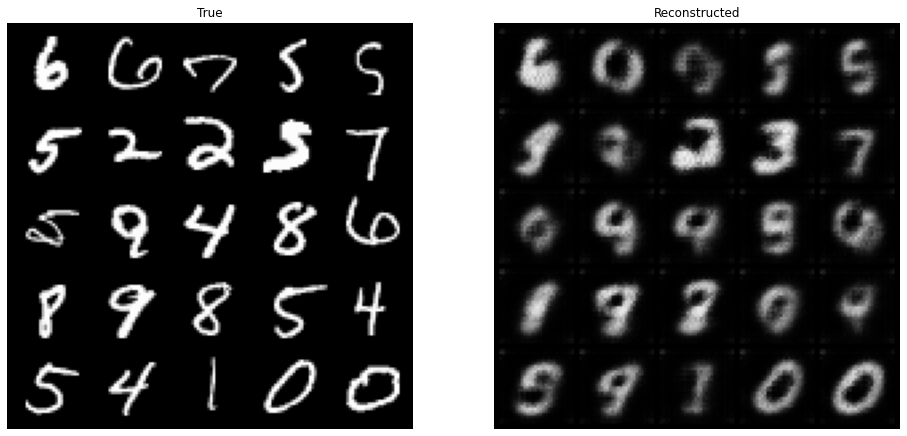

Epoch 1


100%|██████████| 59/59 [00:05<00:00, 11.54it/s]


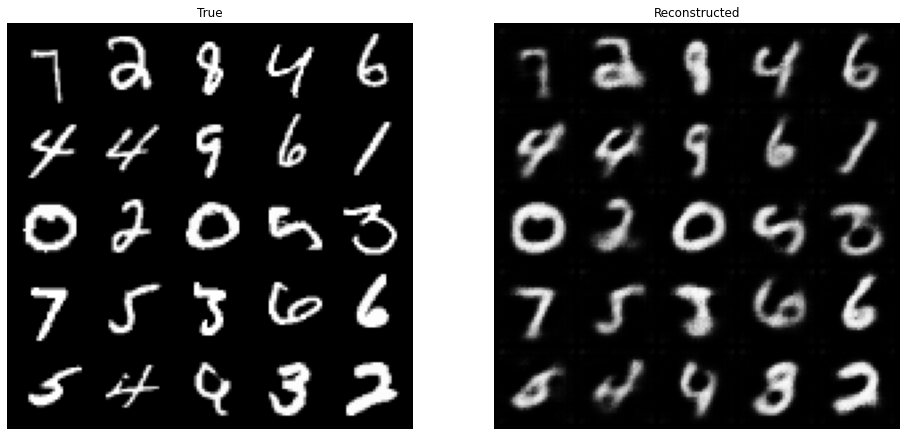

Epoch 2


100%|██████████| 59/59 [00:05<00:00, 11.56it/s]


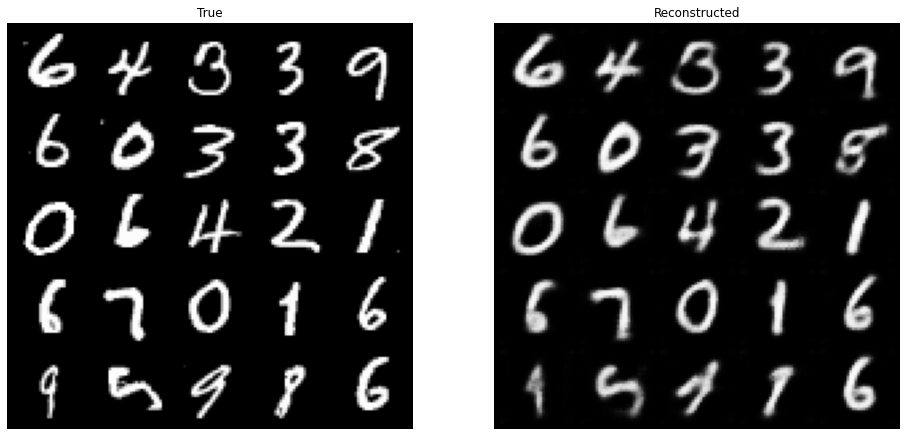

Epoch 3


100%|██████████| 59/59 [00:05<00:00, 11.58it/s]


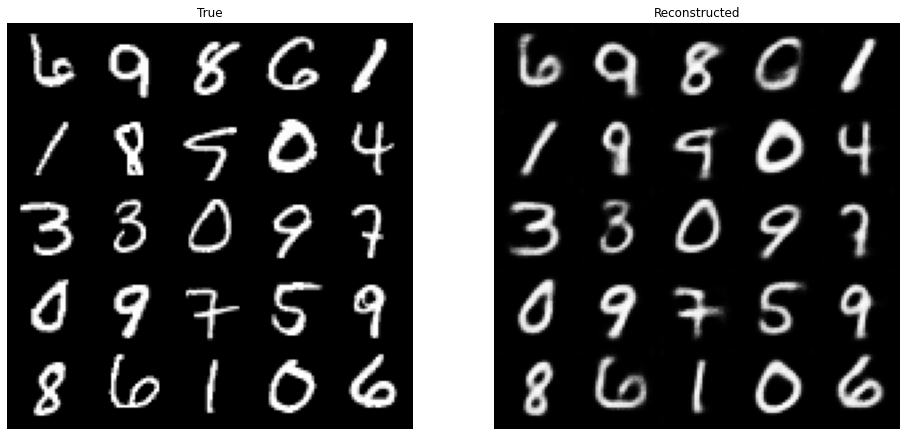

Epoch 4


100%|██████████| 59/59 [00:06<00:00,  8.82it/s]


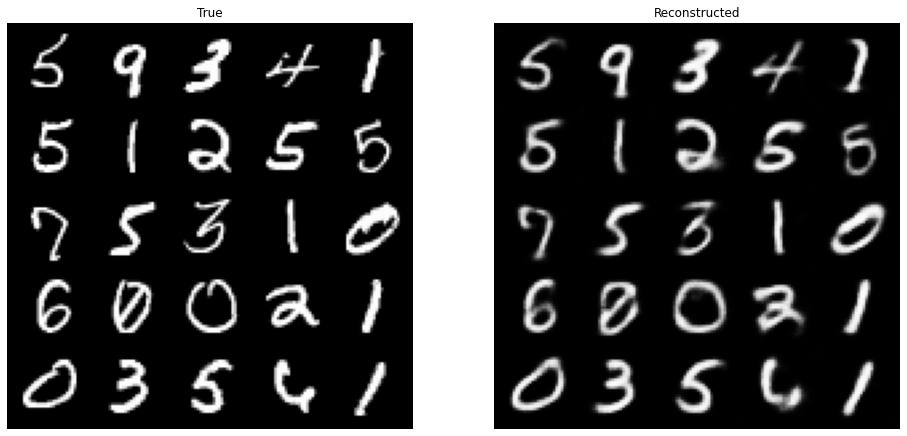

Epoch 5


100%|██████████| 59/59 [00:06<00:00,  8.97it/s]


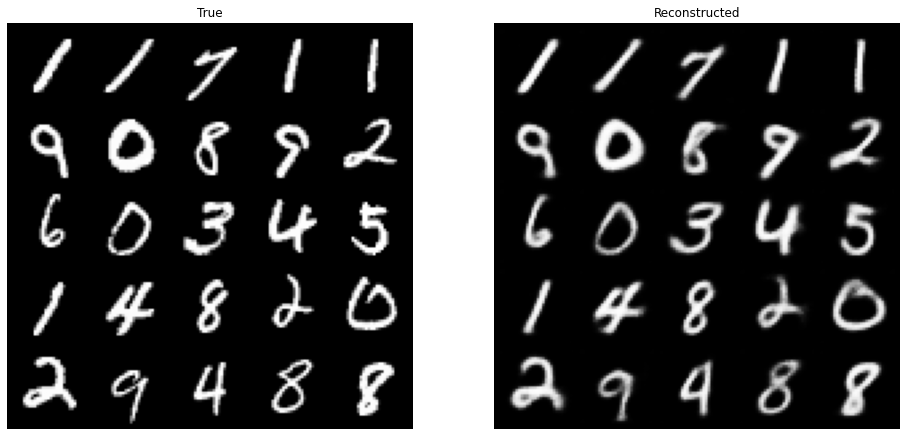

Epoch 6


100%|██████████| 59/59 [00:06<00:00,  9.70it/s]


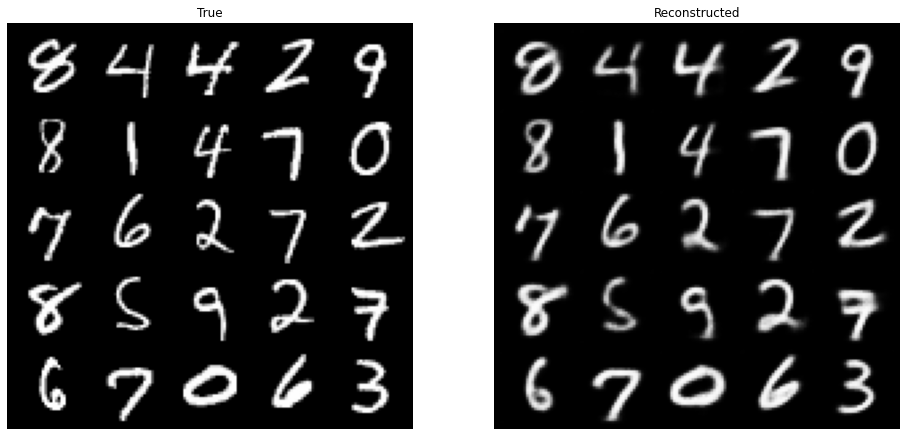

Epoch 7


100%|██████████| 59/59 [00:06<00:00,  9.60it/s]


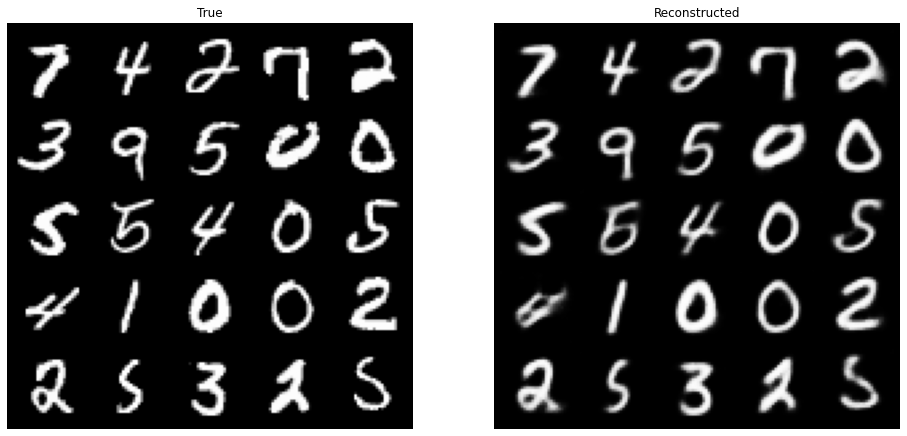

Epoch 8


100%|██████████| 59/59 [00:06<00:00,  9.72it/s]


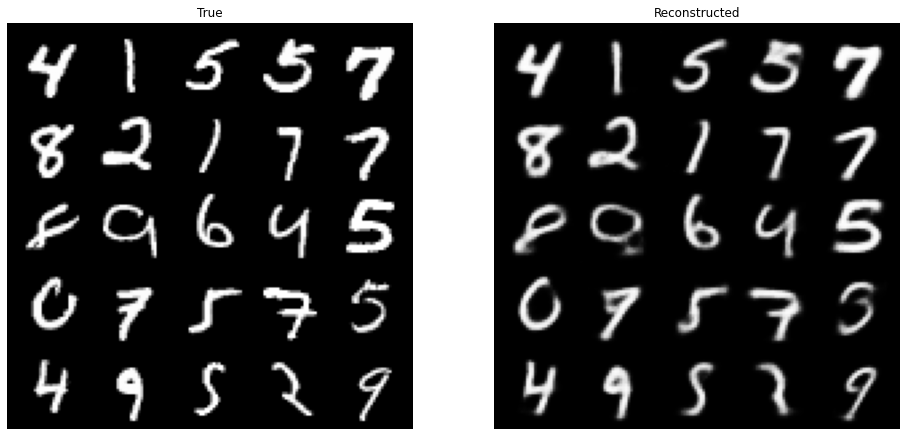

Epoch 9


100%|██████████| 59/59 [00:06<00:00,  9.68it/s]


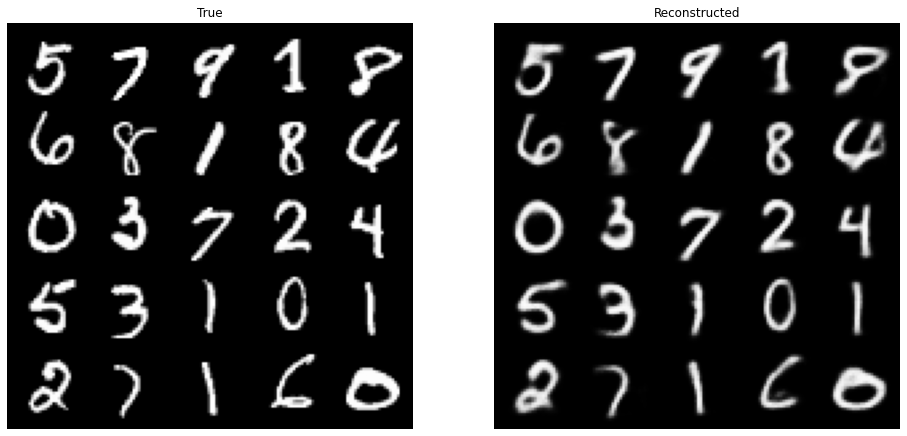

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)
for epoch in range(10):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    for images, _ in tqdm(train_dataloader):
        images = images.to(device)
        vae_opt.zero_grad() # Clear out the gradients
        recon_images, encoding = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        vae_opt.step()
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()

If you're interested in learning more about VAE's here are some useful resources:

*   [$\beta$-VAEs](https://openreview.net/forum?id=Sy2fzU9gl) showed that you can weight the KL-divergence term differently to reward "exploration" by the model. 
*   [VQ-VAE-2](https://arxiv.org/pdf/1906.00446.pdf) is a VAE-Autoregressive hybrid generative model, and has been ablbe to generate incredibly diverse images - keeping up with GANs. :) 
*   [VAE-GAN](https://arxiv.org/abs/1512.09300) is a VAE-GAN hybrid generative model that uses an adversarial loss (that is, the discriminator's judgments on real/fake) on a VAE. 

